In [4]:
!pip install ipywidgets
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.8 MB/s eta 0:00:00


In [2]:
!pip install cvxpy==1.4.1
!pip install cvxpylayers==0.1.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 23.7 MB/s eta 0:00:00
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.3.2
    Uninstalling cvxpy-1.3.2:
      Successfully uninstalled cvxpy-1.3.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 20.1 MB/s eta 0:00:00


**Problem Formulation**
The primary objective of this study is to guide a vehicle to a designated parking spot.The inputs for controlling the vehicle are generated by a MPC controller.

The ultimate goal is to bring the vehicle to a state of zero velocity while meeting specific orientation requirements at the final parking position. This comprehensive approach not only addresses the avoidance of obstacles but also takes into account the precise alignment and stationary state of the vehicle at the conclusion of the maneuver.

I have simulated "Self Parking Car" using bicycle model dynamics. Many vehicle dynamics models exist with varying levels of complexity and accuracy. One commonly used and relatively simple model is referred to as the "bicycle model." Despite its name, the bicycle model is not intended for modeling bicycle handling dynamics. In reality, it would be an inadequate model for bicycle dynamics because it does not consider factors such as roll.

              x_dot = v * cos(ψ)
              y_dot = v * sin(ψ)
              ψ_dot = v * 𝛽 /L
              v_dot = a

I have used four variables in state space equation. x,y coordinates of robot with respect to world frame. ψ being the orientation of the car angle with respect to x-axis and v being the velocity of the car. The inputs to the system are steering angle and acceleration. In this model the car can only move forward, It can break and change the direction of steering wheel.

Here in this case the constraints are acceleration is in between -2 and 2. There are no contraints on velocity.


In [82]:
import cvxpy as cp
import torch
from cvxpylayers.torch import CvxpyLayer
import numpy as np


n_state = 4
n_action = 2
T = 200
dt = 0.02
x_0 = np.array([2.,4.,0.,-1.57])
total_time_step = 200
L=1.45
action_trajectory = []
state_trajectory = []

# environment parameters
FRAME_TIME = 0.1  # time interval
BOOST_ACCEL = 2  # thrust constant  # max rotation rate

def mpc(x_0, T):

    x = cp.Variable((n_state, T + 1))
    u = cp.Variable((n_action, T))
    v = x_0[2]
    theta = x_0[3]
    A = np.array([[1, 0, np.cos(theta)*dt, 0],
                [0, 1,np.sin(theta)* dt, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])
    B = np.array([[0, 0],
                [0, 0],
                [dt * BOOST_ACCEL, 0],
                [0, dt*v/L ]])

    cost = 0
    constr = []
    for t in range(T):
        constr += [x[:, t + 1] == A @ x[:, t] + B @ u[:, t],
                   cp.abs(u[0,t])<=2,
                   cp.abs(u[1,t])<=1
                   ]

    # cost = cp.sum_squares(x[:, T])
    cost = 1200 * cp.square(x[1, T]) + cp.sum_squares(x[:, T])+ 20 * cp.square(x[1, T])

    # sums problem objectives and concatenates constraints.
    constr += [x[:, 0] == x_0]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve()
    return x, u

def visualize(x,u):
    data = x
    action_data = u
    x = data[:, 0]
    y = data[:, 1]
    v = data[:, 2]
    theta = data[:, 3]
    acc = action_data[:,0]
    frame = range(T)

    fig, ax = plt.subplots(1, 4, tight_layout = 1, figsize = (15, 5))

    ax[0].plot(x, y, c = 'b')
    ax[0].set_xlabel("X")
    ax[0].set_ylabel("Y")
    ax[0].set(title=f'Displacement plot(x-y)')

    ax[1].plot(frame, v, c = 'c', label = "Velocity in x")
    #ax[1].plot(frame, vy, c = 'r', label = "Velocity in y")
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("Velocity (m/s)")
    ax[1].legend(frameon=0)
    ax[1].set(title =f'Velocity plot')

    ax[2].plot(frame, theta, c = 'g', label = "theta")
    ax[2].set_xlabel("Time interval")
    ax[2].set_ylabel("Theta")
    ax[2].legend(frameon=0)
    ax[2].set(title=f'Theta plot')

    ax[3].plot(frame, acc, c = 'y', label = "thrust")
    ax[3].set_xlabel("Time interval")
    ax[3].set_ylabel("Thrust")
    ax[3].legend(frameon=0)
    ax[3].set(title=f'Thrust plot')
    plt.show()

def simulate(state, action):
    #delta_state_gravity = np.array([0., 0.,-GRAVITY_ACCEL_X * FRAME_TIME, -GRAVITY_ACCEL_Y * FRAME_TIME, 0.])
    state_tensor = np.zeros(4)
    state_tensor[2] = 1
    theta = state[3]
    v = state[2]
    delta_state = BOOST_ACCEL * FRAME_TIME * state_tensor * action[0]

    # Theta
    delta_state_theta = FRAME_TIME * v * action[1] /L

    # Update state
    step_mat = np.array([[1., 0.,np.cos(theta)*FRAME_TIME, 0.],
                                [0., 1., np.sin(theta)*FRAME_TIME, 0.],
                                [0., 0., 1., 0.],
                                [0., 0., 0., 1.],])


    state = step_mat @ state
    state = state + delta_state
    state[3] += delta_state_theta
    print(state)
    print(action)
    return state

def control(x_0, total_time_step):
    x_current = x_0
    for i in range(total_time_step):
        x, u = mpc(x_current, T-i)

        if u[:,0].value is None: # if the MPC problem is infeasible, stop
            print('MPC infeasible.')
            break

        #visualize(np.array(x[:,:].value).T, np.array(u.value).T)
        action = u[:,0].value
        x_current = simulate(x_current, action)
        action_trajectory.append(action)
        state_trajectory.append(x_current)

control(x_0, total_time_step)


[ 2.          4.          0.15537591 -1.57      ]
[0.77687955 0.        ]
[ 2.00001237  3.98446241  0.29562844 -1.55928519]
[0.70126263 0.99992819]
[ 2.00035267  3.95490153  0.42170336 -1.53889689]
[0.6303746  1.00000669]
[ 2.00169765  3.91275265  0.53324216 -1.50981234]
[0.557694   1.00005344]
[ 2.00494756  3.85952756  0.63148427 -1.47303687]
[0.49121056 1.00000404]
[ 2.01111108  3.79668064  0.71877339 -1.43531863]
[0.43644563 0.8660778 ]
[ 2.0208191   3.72546192  0.7964041  -1.39832788]
[0.38815353 0.74622387]
[ 2.03448656  3.64700305  0.86437783 -1.36210168]
[0.33986865 0.65956458]
[ 2.05239501  3.56244077  0.92293788 -1.32663108]
[0.29280028 0.59502178]
[ 2.0747067   3.47288447  0.97095475 -1.29190117]
[0.24008434 0.54563117]
[ 2.10143647  3.37954074  1.0077422  -1.25790304]
[0.18393723 0.50771981]
[ 2.13245606  3.28365942  1.04046673 -1.22462546]
[0.16362268 0.47881775]
[ 2.16775892  3.18578492  1.06986244 -1.19205633]
[0.14697853 0.45388518]
[ 2.20731709  3.08638065  1.09875091 -

"In the implementation of our Model Predictive Control (MPC) system, it became evident that the cost function, particularly the weights assigned to the state variables, plays a pivotal role in determining controller performance. Initially, with lower weights, the controller yielded negligible values for acceleration and steering angle, indicating an insufficient response to the control objectives. A significant observation was made when the weight on the y-coordinate was increased: there was a noticeable and immediate reduction in the minimum value of the cost function. This highlighted the sensitivity of the system's performance to the weight parameters. Therefore, a substantial portion of the tuning process was dedicated to adjusting these weights, which ultimately proved crucial in achieving the desired final state. This iterative approach to tuning, focused on the cost function's weights, was key in refining the controller's efficacy and aligning it with our specific control goals."

Generating Animation


IntProgress(value=0, max=200)

(200, 4) (200, 2)


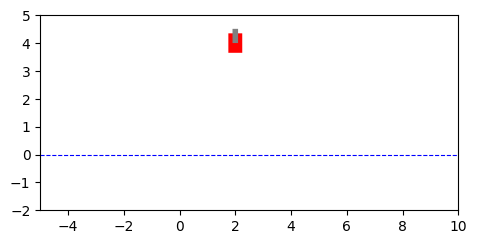

In [83]:
def animation(state_trajectory, action_trajectory):
        length = 0.10          # m
        width = 0.02          # m

        v_exhaust = 1
        print("Generating Animation")
        steps = min(len(state_trajectory), len(action_trajectory))
        final_time_step = round(1/steps,2)
        f = IntProgress(min = 0, max = steps)
        display(f)

        data = np.array(state_trajectory)
        action_data = np.array(action_trajectory)
        x_t = data
        u_t = action_data
        print(x_t.shape, u_t.shape)

        fig = plt.figure(figsize = (5,8), constrained_layout=False)
        ax1 = fig.add_subplot(111)
        plt.axhline(y=0., color='b', linestyle='--', lw=0.8)

        ln1, = ax1.plot([], [], linewidth = 10, color = 'red') # rocket body
        ln6, = ax1.plot([], [], '--', linewidth = 2, color = 'yellow') # trajectory line
        ln2, = ax1.plot([], [], linewidth = 4, color = 'grey') # thrust line

        plt.tight_layout()

        ax1.set_xlim(-5, 10)
        ax1.set_ylim(-2, 5)
        ax1.set_aspect(1)  # aspect of the axis scaling, i.e. the ratio of y-unit to x-unit

        def update(i):
            rocket_theta = x_t[i, 3]

            rocket_x = x_t[i, 0]
            # length/1 is just to make rocket bigger in animation
            rocket_x_points = [rocket_x + length/1 * np.cos(rocket_theta), rocket_x - length/1 * np.cos(rocket_theta)]

            rocket_y = x_t[i, 1]
            rocket_y_points = [rocket_y + length/1 * np.sin(rocket_theta), rocket_y - length/1 * np.sin(rocket_theta)]

            ln1.set_data(rocket_x_points, rocket_y_points)

            thrust_mag = u_t[i, 0]
            thrust_angle = -u_t[i, 1]

            flame_length = (thrust_mag) * (0.4/v_exhaust)
            # flame_x_points = [rocket_x_points[1], rocket_x_points[1] + flame_length * np.sin(thrust_angle - rocket_theta)]
            # flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.cos(thrust_angle - rocket_theta)]
            flame_x_points = [rocket_x_points[1], rocket_x_points[1] - flame_length * np.cos(rocket_theta)]
            flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.sin(rocket_theta)]

            ln2.set_data(flame_x_points, flame_y_points)
            ln6.set_data(x_t[:i, 0], x_t[:i, 1])
            f.value += 1

        playback_speed = 5000 # the higher the slower
        anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

        # Save as GIF
        writer = PillowWriter(fps=20)
        anim.save("self_driving_mpc.gif", writer=writer)

animation(state_trajectory, action_trajectory)
